In [115]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import smogn
import seaborn as sns

In [133]:
seed = 77

In [135]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.9,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.08,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

# scale the numerical features only (this leaves out the dummy features from earlier)

from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(40)['features'])

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))
    
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

r_index: 100%|##########| 94/94 [00:00<00:00, 312.00it/s]
D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

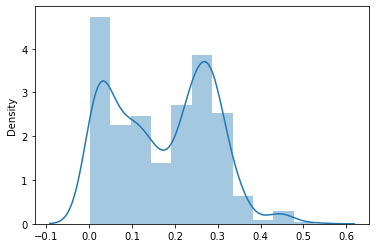

In [136]:
sns.distplot(y)

In [117]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in tree
n_estimators = range(25, 450, 15)

# Maximum number of levels in tree
max_depth = range(3, 10, 2)

min_child_weight = range(1,7)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'gamma':[i/10.0 for i in range(0,20)],
               'colsample_bytree': [i/100.0 for i in range(60, 90, 5)],
               'learning_rate': [i/100.0 for i in range(5, 20, 5)],
               'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

In [137]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 300, cv = 7, verbose=3, random_state=seed, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


RandomizedSearchCV(cv=7,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.65, 0.7,
                                                             0.75, 0.8,

In [138]:
xgb_random.best_params_

{'reg_alpha': 1e-05,
 'n_estimators': 370,
 'min_child_weight': 3,
 'max_depth': 9,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.8}

In [ ]:
reg_alpha= 1e-05,
 n_estimators= 370,
 min_child_weight= 3,
 max_depth= 9,
 learning_rate= 0.05,
 gamma= 0.0,
 colsample_bytree= 0.8

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
xgb = XGBRegressor(reg_alpha= 0.1,
 n_estimators= 130,
 min_child_weight= 4,
 max_depth= 5,
 learning_rate= 0.15,
 gamma= 0.0,
 colsample_bytree= 0.7,
scale_pos_weight = 1)

grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch = GridSearchCV(estimator = xgb, 
                       param_grid = grid, n_jobs=-1, cv=5)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    gamma=0.0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=85, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=1, subsample=None,
                                    tree_method=None, validate_parameters=None,


In [78]:
gsearch.best_params_

{'reg_alpha': 1e-05}

In [139]:
xgb = XGBRegressor(reg_alpha= 1e-05,
 n_estimators= 370,
 min_child_weight= 3,
 max_depth= 9,
 learning_rate= 0.05,
 gamma= 0.0,
 colsample_bytree= 0.8)

run(xgb, "XGB", X_train, X_val)

[XGB] These are the results for the training set.
r^2:  0.9999321634040292
mse:  8.83443942737195e-07
variance_score:  0.9999321634319438
mse-log:  6.183726134380546e-07
--------------------------------------
[XGB] These are the results for the validation set.
r^2:  0.8703553073848966
mse:  0.001879737799785272
variance_score:  0.8703762839018823
mse-log:  0.0012417455603565453
_____________________________________________


In [140]:
evaluate(xgb.predict(X_test), y_test)

r^2:  0.7771266677359601
mse:  0.0017146940394034923
variance_score:  0.7925521816590111
mse-log:  0.0013942991324292719


In [141]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [142]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=xgb.predict(X_test))], axis=1)

In [143]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
108,2016,Randy Foye,20.3,6.166667,19.814815,0.4,1.047210,3708,0.026555,0.028488
326,2019,Jake Layman,18.7,5.971831,18.690141,3.1,1.047391,2836,0.032820,0.040779
250,2018,Luc Mbah a Moute,25.6,5.655738,25.639344,2.8,2.345739,3541,0.042412,0.100842
87,2016,Jason Terry,17.5,5.222222,17.472222,1.5,0.185474,2883,0.016482,0.036233
360,2019,Shaquille Harrison,19.6,5.835616,19.589041,1.4,-0.100122,3009,0.008231,0.026086
324,2019,Reggie Bullock,29.8,10.022727,30.795455,3.1,0.530684,3957,0.036650,0.077106
320,2019,Daniel Theis,13.8,4.030303,13.757576,3.5,1.453792,2039,0.045813,0.035457
77,2016,Marreese Speights,11.6,6.333333,11.555556,1.8,0.392331,2157,0.014909,0.055495
347,2019,Quinn Cook,14.3,5.932432,14.310811,1.8,-0.405645,2626,0.027488,0.050801
204,2017,Josh McRoberts,17.3,5.363636,17.318182,0.3,0.060565,739,0.060763,0.028356
